# pyGATB: presentation and usage

```bash
git clone --recursive https://github.com/Piezoid/pyGATB
cd pyGATB
mkdir build && cd build
cmake . .. -DCMAKE_BUILD_TYPE=Release
make -j8
python3 setup.py install --user
```

In [1]:
from pyGATB.graph import Graph

In [2]:
graph = Graph('DiscoSnp/test/large_test/discoRes_k_31_c_auto.h5') # chr1 with simulated variants
graph

<Graph k31 INIT_DONE>

In [3]:
help(graph)

Help on Graph object:

class Graph(builtins.object)
 |  A classic GATB graph.
 |  Nodes objects obtained by iteration contain the actual API
 |  
 |  Methods defined here:
 |  
 |  __contains__(...)
 |      Checks if the neighbor of a real node is in the graph
 |      eg: ``graph[bytes(node)[1:] + b'A'] in graph`` tests if the
 |      right extension with 'A' is present in the graph.
 |      False positives happen when the made up Node is further appart than
 |      one edge to a real Node.
 |  
 |  __getitem__(...)
 |      Construct a Node from a k-mer in bytes
 |      Warning: as usual, don't get off track !
 |  
 |  __iter__(...)
 |      Iterates over branching nodes.
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  kmers(self, s)
 |      Graph.kmers(signatures, args, kwargs, defaults)
 |  
 |  nodes(...)
 |      Graph.nodes(self)
 |     

Iterate over branching nodes:

In [4]:
for i, node in enumerate(graph):
    print('{}: {!r}'.format(i, node))
    if i > 10: break   

0: <Node k31 AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAC F>
1: <Node k31 AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAT F>
2: <Node k31 AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAG F>
3: <Node k31 AAAAAAAAAAAAAAAAAAAAAAAAAAAAACA F>
4: <Node k31 AAAAAAAAAAAAAAAAAAAAAAAAAAAAACC F>
5: <Node k31 AAAAAAAAAAAAAAAAAAAAAAAAAAAAACT F>
6: <Node k31 AAAAAAAAAAAAAAAAAAAAAAAAAAAAACG F>
7: <Node k31 AAAAAAAAAAAAAAAAAAAAAAAAAAAAATA F>
8: <Node k31 AAAAAAAAAAAAAAAAAAAAAAAAAAAAATC F>
9: <Node k31 AAAAAAAAAAAAAAAAAAAAAAAAAAAAATT F>
10: <Node k31 AAAAAAAAAAAAAAAAAAAAAAAAAAAAAGA F>
11: <Node k31 AAAAAAAAAAAAAAAAAAAAAAAAAAAAAGC F>


Graph is a factory for Nodes:

In [5]:
kmer = b'AACGAGCACCAAAGACTTAGCATGAAAACCC'
node = graph[kmer] # Either a real graph node or one of their neighbors
node

<Node k31 AACGAGCACCAAAGACTTAGCATGAAAACCC F>

In [6]:
help(node)

Help on Node object:

class Node(builtins.object)
 |  Methods defined here:
 |  
 |  __bytes__(...)
 |      Node.__bytes__(self)
 |  
 |  __copy__(...)
 |      Node.__copy__(self)
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getitem__(self, key, /)
 |      Return self[key].
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |      Return hash(self).
 |  
 |  __iter__(...)
 |      iterates nucleotides
 |  
 |  __le__(self, value, /)
 |      Return self<=value.
 |  
 |  __len__(self, /)
 |      Return len(self).
 |  
 |  __lt__(self, value, /)
 |      Return self<value.
 |  
 |  __ne__(self, value, /)
 |      Return self!=value.
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  __str__(self, /)
 |      Return str(self).
 |  

In [7]:
bytes(node) # Conversion to bytestring encoded kmer

b'AACGAGCACCAAAGACTTAGCATGAAAACCC'

In [8]:
assert node.reversed == node
node.reversed

<Node k31 GGGTTTTCATGCTAAGTCTTTGGTGCTCGTT R>

Query neighbors and degrees:

In [9]:
print(node.succs, node.out_degree)
print(node.preds, node.in_degree)

(<Node k31 ACGAGCACCAAAGACTTAGCATGAAAACCCA F>, <Node k31 ACGAGCACCAAAGACTTAGCATGAAAACCCT F>) 2
(<Node k31 CAACGAGCACCAAAGACTTAGCATGAAAACC F>,) 1


Query neighbors by manually doing the extension:

In [10]:
node_kmer = bytes(node)
for ext in b'ATGC':# NB: iterating over bytes produces character codes
    ext = bytes((ext,)) # So this line reconstruct a single character bytes object
    ext_kmer = node_kmer[1:] + ext 
    
    ext_node = graph[ext_kmer] # Construct the Node from the bytes encoded kmer
    if ext_node in graph: # Checks if the node belong to the graph
        print(ext_node)


ACGAGCACCAAAGACTTAGCATGAAAACCCA
ACGAGCACCAAAGACTTAGCATGAAAACCCT


Simple paths from neighbors are obtained as list of (path, end node, end reason):

In [11]:
node.paths

((b'AGCGTCCCCTCTTCCACACTGCCCTGATCCCC',
  <Node k31 GCGTCCCCTCTTCCACACTGCCCTGATCCCC F>,
  2),
 (b'TGCGTCCCCTCTTCCACACTGCCCTGATCCCC',
  <Node k31 GCGTCCCCTCTTCCACACTGCCCTGATCCCC F>,
  2))

Both paths ends at the same k-mer : this is a bubble induced by A/T on the first nucleotide in the path.

This code tests the forward paths results for all branching nodes and their RCs:

In [12]:
def check_paths(origin_node):
    origin_node_kmer = bytes(origin_node)
    for path, end_node, end_reason in origin_node.paths:
        assert (origin_node_kmer + path).endswith(bytes(end_node))
        if end_reason == 2: # In-branching end reason prioritized over out-branching
            assert end_node.in_degree > 1
        elif end_reason == 1:
            assert end_node.out_degree > 1 # Out-branching
        elif end_reason == 3: # Dead-end
            assert end_node.out_degree == 0

for origin_node in graph:
    check_paths(origin_node)
    origin_node.reverse() # in-place reverse
    check_paths(origin_node)

# Example: forward simple paths graph

A graph (branching node, simple path) is constructed by a bounded breadth first seach over forward simple paths.
The start node is the running example (`AACGAGCACCAAAGACTTAGCATGAAAACCC`) of a node preceding a bubble.

The edges (paths) visited by the BFS are then displayed with `igraph :
* Red node : root node (start point of the BFS)
* yellow node: node with in-branching (predecesors are not fetched by the forward seach),
* blue node: node with out-branching,
* green node: in and out-branching,
* Red circle: nodes with unexplored descendants.

The numbers on the edges are the simple path lengths.

260 nodes, 268 edges.


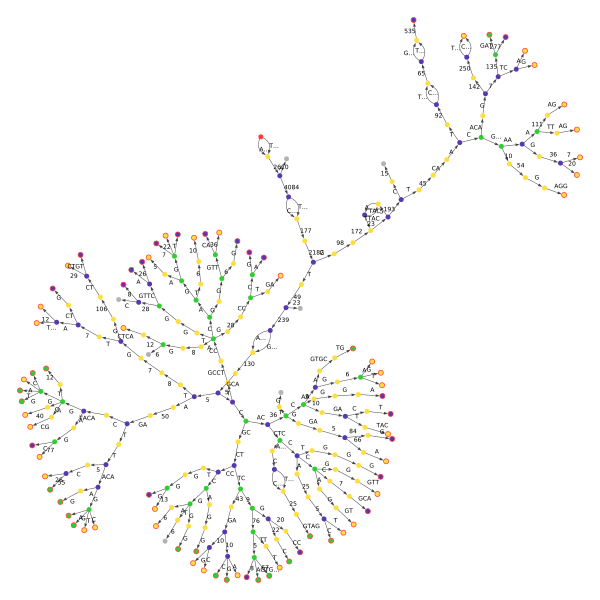

In [13]:
from plot_graph import bfs_igraph
bfs_igraph(node, max_depth=20)